<img src="./resources/images/banner3.png" width="100%" alt="Encabezado MLDS">

# **Extracción de Características**
---

## **0. Integrantes del equipo de trabajo**
---

<table><thead>
  <tr>
    <th>#</th>
    <th>Integrante</th>
    <th>Documento de identidad</th>
  </tr></thead>
<tbody>
  <tr>
    <td>1</td>
    <td>Ivonne Cristina Ruiz Páez</td>
    <td>1014302058</td>  
  </tr>
  <tr>
    <td>2</td>
    <td>Diego Alejandro Feliciano Ramos</td>
    <td>1024586904</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Cristhian Enrique Córdoba Trillos</td>
    <td>1030649666</td>
  </tr>
</tbody>
</table>

## **1. Selección del Embedding**
---

Para el análisis de sentimientos sobre un corpus de 50.000 documentos en inglés provenientes de redes sociales, se seleccionó la técnica de embedding FastText por su capacidad de generar representaciones distribuidas de palabras que incorporan información subléxica a través del modelado de n-gramas de caracteres. A diferencia de Word2Vec, que representa cada palabra como un vector independiente, FastText descompone las palabras en subcomponentes, lo cual permite manejar de forma más robusta errores ortográficos, abreviaciones y palabras fuera del vocabulario (OOV), fenómenos frecuentes en el lenguaje informal y no estructurado característico de las plataformas sociales. Esta propiedad resulta especialmente útil para capturar de manera más precisa el contenido semántico de los textos breves y ruidosos. Además, su eficiencia computacional lo hace adecuado para corpus de tamaño medio-grande como el presente, permitiendo generar embeddings útiles para tareas de clasificación sin incurrir en los altos costos de cómputo de modelos basados en transformers. Si bien FastText no produce embeddings contextuales, su generalización a partir de subpalabras ofrece una mejora significativa sobre técnicas tradicionales como TF-IDF o Bag-of-Words, posicionándolo como una alternativa balanceada en términos de precisión y escalabilidad para tareas de análisis de sentimientos en dominios informales como las redes sociales.

## **2. Implementación del Embedding**
---

Implemente la estrategia de embedding a partir del conjunto de datos pre-procesado. Recuerde que:

- `sklearn`: permite implementar bolsas de palabras, TF-IDF y bolsas de N-grams a partir del módulo `sklearn.feature_extraction.text`.
- `gensim`: permite implementar word2vec, fasttext y doc2vec desde `gensim.models`.
- `spacy`: permite representar textos con embeddings pre-entrenados con el atributo `vector`.

In [ ]:
%pip install textblob kagglehub emoji gensim pandas numpy wordcloud contractions langdetect tqdm

In [ ]:
import re
import time
import logging
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, TimeoutError

from tqdm import tqdm  

import nltk
import kagglehub
import pandas as pd

from emoji import demojize
import contractions
from langdetect import detect, DetectorFactory
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from textblob import download_corpora

In [ ]:
# Función para detectar idioma
def detectar_idioma(texto):
    try:
        return detect(str(texto))
    except:
        return "unknown"

In [ ]:
OUTPUT_CSV = "./dataset_limpio.csv"
TEXT_COLUMN = "statement"
TIMEOUT_SEGUNDOS = 5

# Flag opcional para activar corrección
CORREGIR_ORTOGRAFIA = True

In [ ]:
def limpiar_texto(texto):
    # 0. Asegurar que sea string
    texto = str(texto)

    # 1. Expandir contracciones ("I'm" -> "I am")
    texto = contractions.fix(texto)

    # 2. Demojizar 
    texto = demojize(texto)

    # 3. Reemplazar URLs, menciones, hashtags
    texto = re.sub(r"http\S+|www\S+|https\S+", " ", texto)
    texto = re.sub(r"@\w+", " ", texto)
    texto = re.sub(r"#(\w+)", r"\1", texto)

    # 4. Reemplazar puntuación por espacios
    texto = re.sub(r"[^a-zA-Z]", " ", texto)

    # 5. Minúsculas
    texto = texto.lower()

    # 6. Tokenización
    tokens = word_tokenize(texto)

    # 7. Filtro de tokens
    tokens_filtrados = [
        token for token in tokens
        if token not in stop_words and len(token) > 1 and token.isalpha()
    ]

    # 8. Corrección ortográfica opcional
    if CORREGIR_ORTOGRAFIA:
        tokens_corregidos = []
        for token in tokens_filtrados:
            palabra_corregida = str(TextBlob(token).correct())
            tokens_corregidos.append(palabra_corregida)
    else:
        tokens_corregidos = tokens_filtrados

    # 9. Lematización
    tokens_lemmatizados = [lemmatizer.lemmatize(token) for token in tokens_corregidos]

    # 10. Retornar lista final de tokens
    return tokens_lemmatizados

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /Users/diegof/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/diegof/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /Users/diegof/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/diegof/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /User

In [ ]:
def timeout_en_limpieza(texto):
    with ThreadPoolExecutor(max_workers=1) as executor:
        futuro = executor.submit(limpiar_texto, texto)
        try:
            return futuro.result(timeout=TIMEOUT_SEGUNDOS)
        except TimeoutError:
            logging.warning("⏱ Timeout en limpieza: " + str(texto[:40] + "\n"))
            return []
        except Exception as e:
            logging.error(f"❌ Error al limpiar texto: {texto[:40]}... -> {str(e)} \n")
            return []

In [ ]:
# Descarga la última versión del dataset
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)
# Carga la data del dataset
path = '/Users/diegof/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv'
df = pd.read_csv(path)

In [ ]:
def procesar_en_paralelo(funcion, lista_textos, num_procesos=None):
    if num_procesos is None:
        from os import cpu_count
        num_procesos = cpu_count()
    with mp.Pool(processes=num_procesos) as pool:
        resultados = list(tqdm(pool.imap(funcion, lista_textos), total=len(lista_textos)))
    return resultados

In [ ]:

if __name__ == "__main__":
    start = time.time()
    try:
        logging.info("🚀 Inicio del procesamiento")
        print("📦 Cargando datos...")
        print(f"✅ {len(df)} documentos cargados.")
        logging.info(f"{len(df)} documentos cargados.")

        print("🌍 Detectando idioma...")
        df["lang"] = df[TEXT_COLUMN].apply(detectar_idioma)
        df_ingles = df[df["lang"] == "en"].copy()
        print(f"✅ Documentos en inglés: {len(df_ingles)}")

        print("🧠 Procesando en paralelo con timeout por fila...")
        textos = df_ingles[TEXT_COLUMN].tolist()
        textos_limpios = procesar_en_paralelo(timeout_en_limpieza, textos, num_procesos=11)

        print("💾 Guardando resultados...")
        df["clean_tokens"] = textos_limpios
        df.to_csv(OUTPUT_CSV, index=False)
        logging.info(f"Archivo guardado como: {OUTPUT_CSV}")
        print(f"✅ Archivo guardado como: {OUTPUT_CSV}")
    except Exception as e:
        print("❌ Error durante el procesamiento:")
        print(e)
        logging.error(f"Error general del script: {str(e)}")
    finally:
        end = time.time()
        elapsed = (end - start) / 60
        print(f"⏱ Tiempo total: {elapsed:.2f} minutos")
        logging.info(f"Tiempo total: {elapsed:.2f} minutos")

In [4]:
!python ./resources/scripts/procesar_corpus.py

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /Users/diegof/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/diegof/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /Users/diegof/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/diegof/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /User

In [74]:
import requests
url = "https://drive.google.com/uc?export=download&id=1MfG4qCfqAlj7JBWS0WmLQVOZZvY8wPRf"
r = requests.get(url)

with open("dataset.csv", "wb") as code:
    code.write(r.content)

df_cargado = pd.read_csv("dataset.csv")    

In [76]:
import ast

def forzar_listas_en_columna(df, columna):
    """
    Convierte todos los valores de la columna en listas reales, si es posible.
    Devuelve un error si al final hay valores que no son listas.
    """
    def convertir(x):
        if isinstance(x, list):
            return x
        if isinstance(x, str) and x.strip().startswith("[") and x.strip().endswith("]"):
            try:
                return ast.literal_eval(x)
            except Exception as e:
                print(f"⚠️ Error al convertir: {x[:60]}... -> {e}")
                return []  
        return []

    # Aplicar conversión
    df[columna] = df[columna].apply(convertir)

    # Validación final
    tipos_finales = df[columna].apply(type).value_counts()
    print("\n📊 Tipos después de forzar a listas:")
    print(tipos_finales)

    if any(t != list for t in df[columna].apply(type).unique()):
        raise TypeError("❌ Aún hay elementos que no son listas en la columna.")

    return df

# Usar en el dataframe cargado
df_corregido = forzar_listas_en_columna(df_cargado, "clean_tokens")



📊 Tipos después de forzar a listas:
clean_tokens
<class 'list'>    49710
Name: count, dtype: int64


In [77]:
from gensim.models import FastText

# Entrenamiento del modelo FastText
modelo_fasttext = FastText(
    sentences=df_corregido['clean_tokens'],         # lista de listas de tokens
    vector_size=100,                                # dimensión de los embeddings
    window=5,                                       # contexto de palabras
    min_count=2,                                    # ignora palabras con frecuencia < 2
    sg=1,                                           # usa Skip-gram (1) o CBOW (0)
    epochs=10                                       # número de épocas de entrenamiento
)

# Guardar el modelo para reutilización
modelo_fasttext.save("modelo_fasttext_gensim.model")

In [78]:
import numpy as np

def vectorizar_documento(tokens, modelo):
    vectores = [modelo.wv[token] for token in tokens if token in modelo.wv]
    if vectores:
        return np.mean(vectores, axis=0)
    else:
        return np.zeros(modelo.vector_size)

In [79]:
# Vectorizar todos los documentos preprocesados
X_vectores = np.array([vectorizar_documento(tokens, modelo_fasttext) for tokens in df_cargado['clean_tokens']])

# Ver tamaño del resultado
print(X_vectores.shape)

(49710, 100)


## **3. Exploración del Embedding**
---

Puede explorar la representación obtenida por medio de distintas técnicas de visualización o métricas:

- **Análisis de Correlaciones**: si tiene una variable objetivo, puede evaluar correlaciones entre los embeddings y dicha variable.
- **Nubes de palabras**: puede utilizar gráficos de tipo `wordcloud` para visualizar representaciones basadas en conteos
- **Distribuciones**: puede calcular histogramas o gráficos de densidad para mostrar la distribución de embeddings semánticos.

In [80]:
# Palabras similares a "happy"
modelo_fasttext.wv.most_similar("happy", topn=10)

[('happywhen', 0.7625325322151184),
 ('happier', 0.6687446236610413),
 ('sad', 0.6578009128570557),
 ('miserable', 0.6423237323760986),
 ('enjoys', 0.6382735371589661),
 ('smile', 0.6369420289993286),
 ('happiness', 0.6315668225288391),
 ('happiest', 0.6243457794189453),
 ('sappy', 0.6239548325538635),
 ('fun', 0.6169488430023193)]

In [81]:
# Similitud entre pares
print("Similitud entre happy y joyful: " + str(modelo_fasttext.wv.similarity("happy", "joyful")))
print("Similitud entre happy y angry: " + str(modelo_fasttext.wv.similarity("happy", "angry")))

Similitud entre happy y joyful: 0.5925616
Similitud entre happy y angry: 0.43437904


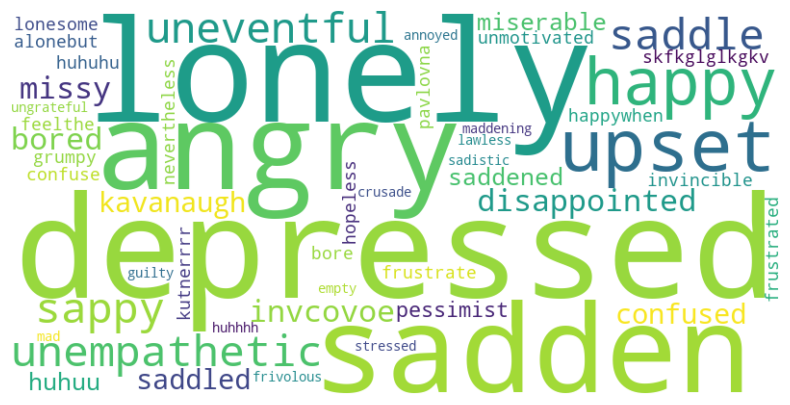

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def nube_palabras(lista_palabras):
    texto = ' '.join(lista_palabras)
    nube = WordCloud(width=800, height=400, background_color='white').generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(nube, interpolation='bilinear')
    plt.axis("off")
    plt.show()

palabras_similares = [w for w, _ in modelo_fasttext.wv.most_similar("sad", topn=50)]
nube_palabras(palabras_similares)

## **Créditos**

* **Profesor:** [Felipe Restrepo Calle](https://dis.unal.edu.co/~ferestrepoca/)
* **Asistentes docentes:**
    - [Juan Sebastián Lara Ramírez](https://www.linkedin.com/in/juan-sebastian-lara-ramirez-43570a214/).
* **Diseño de imágenes:**
    - [Rosa Alejandra Superlano Esquibel](mailto:rsuperlano@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*